In [ ]:
import matplotlib.pyplot as plt
import imageio.v2 as iio
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import directed_hausdorff
from sklearn import decomposition
from skimage import registration,img_as_bool
from skimage.transform import warp, downscale_local_mean, EuclideanTransform, rotate
from skimage import img_as_float32
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops, marching_cubes
import mrcfile
import math
import napari
from skimage.metrics import hausdorff_distance, hausdorff_pair, mean_squared_error
from skimage.filters import threshold_otsu, sobel
from skimage.draw import line_nd, ellipse, polygon
import time
from tqdm import tqdm
from itertools import product
import multiprocessing
import concurrent.futures

from src import asymmetry_3D
from src import prepare_center_pca
from src.asymmetry_3D import *
from src.utils import *
from src.prepare_center_pca_3D import *

%load_ext autoreload
%autoreload 2
V = napari.Viewer(ndisplay = 3)

1. Load data

A note on python arrays: they start indexing at 0 i.e., the first element of an array is Array[0], unlike matlab where this would be Array(1)\
Volume images are arrays with 3 axes. In python the axes order is Array[z, y, x], see the schematic below\
\
Important! At the moment, this code assumes that the images have been binarized previously. All background pixels are 0.

The computation takes a few minutes for volumes ~ 100 x 150 x 100 voxels, increase this at your own risk!\
*TO DO*\
automate BFGS bounds

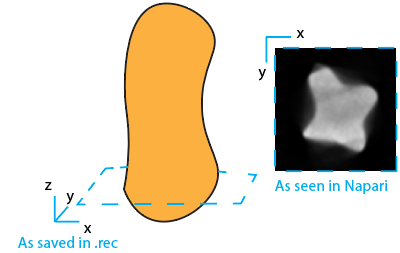

In [3]:
filename = 'test/chiral_TwistedPT.tif' # Data must be binarized but not necessarily aligned
Q = read_data(filename) # Can read .tif(f), .mrc, .rec

print(f'volume size: {Q.shape}')
print(f'number of voxels: {Q.shape[0]*Q.shape[1]*Q.shape[2]}')
print(f'number of surface voxels: {np.count_nonzero(get_edges(Q))}')

volume size: (147, 93, 93)
number of voxels: 1271403
number of surface voxels: 33359


Run the cell below if the data have not been aligned to center and major axis vertical yet. This calculation requires the long axis of the image to be in position 0

In [ ]:
Q = translate_center_of_mass(Q)
Q = rotate_pca(Q)

2. Perform an initial grid search. Watch out! Computation cost scales with ${N_{parameters}}^6$ and ~ ${N_{voxels}}^1$

In [20]:
''' Parameters ''' 
n_shifts = 3 # for now, must be odd to include 0
l_shifts = 1 # in pixels
n_angles = 20 # 60 angles is quite good already, must be even for rod_like

distance = 'SE' # 'IoU', 'SE' or 'Hausdorff'
rod_like = True # if True, will limit rotations to the major and 1 minor axes, with [-10°+10°] at +/- 180° for the minor

''' Function '''
if n_shifts == 0:
    iter_u = [0]
    iter_v = [0]
    iter_w = [0]
else:
    lim = (n_shifts // 2) * l_shifts
    iter_u = np.linspace(-1 * lim, lim, n_shifts,  dtype = 'int') # number of X points in the grid search, centered
    iter_v = np.linspace(-1 * lim, lim, n_shifts, dtype = 'int') # number of Y points in the grid search, centered
    iter_w = np.linspace(-1 * lim, lim, n_shifts, dtype = 'int') # number of Z points in the grid search, centered

if rod_like:
    iter_a = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int') # rotations about Z axis
    n_angles_minor_ud = n_angles // 2
    if not n_angles_minor_ud % 2:
        n_angles_minor_ud -= 1
    iter_b = np.concatenate([ 
        np.linspace(-10, 10, n_angles_minor_ud, endpoint = True, dtype = 'int'),
        np.linspace(170, 190, n_angles_minor_ud, endpoint = True, dtype = 'int')
    ]) # rotations about Y axis
    iter_c = [0] # rotations about X axis

else:
    iter_a = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int') # rotations about Z axis
    iter_b = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int') # rotations about Y axis
    iter_c = np.linspace(0, 360, n_angles, endpoint = False, dtype = 'int') # rotations about X axis


# Need to decouple col, row and angle idx to have a finer search with angles
# Also could have a "rod" or "sphere" case where less rotation are required

print(f'Grid search in u: {iter_u}')
print(f'Grid search in v: {iter_v}')
print(f'Grid search in w: {iter_w}')

print(f'Grid search in a: {iter_a}')
print(f'Grid search in b: {iter_b}')
print(f'Grid search in c: {iter_c}')

iter_param = [(u, v, w, a, b, c) 
              for u in iter_u
              for v in iter_v
              for w in iter_w 
              for a in iter_a
              for b in iter_b
              for c in iter_c]

Q_mirror = np.flip(Q, axis = 1)

print(f'The global minimum will be searched with {distance} over {len(iter_param)} combinations')
print(f'Estimated computation time: {eval_time_grid_search(Q, distance, iter_param)} s')

Grid search in u: [-1  0  1]
Grid search in v: [-1  0  1]
Grid search in w: [-1  0  1]
Grid search in a: [  0  18  36  54  72  90 108 126 144 162 180 198 216 234 252 270 288 306
 324 342]
Grid search in b: [-10  -8  -5  -3   0   2   5   7  10 170 172 175 177 180 182 185 187 190]
Grid search in c: [0]
The global minimum will be searched with SE over 9720 combinations
Estimated computation time: 63 s


In [21]:
''' Function '''
print(f'Searching the global minimum over {len(iter_param)} combinations ...')

# Multithreaded
to_CPU = [(Q, param, distance) for param in enumerate(iter_param)] # here param is [idx, (u, v, w, a, b, c)]

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(to_multiprocessing_3D, var) for var in to_CPU]
    H_global = [future.result() for future in concurrent.futures.as_completed(futures)]

# Retrieve results H_global [idx | distance]
H_global = np.array(H_global)
min_param_idx = H_global[np.argmin(H_global[:,1]), 0] # Get the lowest distance
min_param = iter_param[int(min_param_idx)]

# Rearrange H_global for [idx | u | v | alpha | distance]
H_global = H_global[np.argsort(H_global[:,0])] # Sort by idx
for i in range(len(iter_param[0])):
    H_global = np.insert(H_global, i+1, np.asarray(iter_param)[:,i], axis = 1) # Insert param

# Print results
print(f'global minimum found for parameters: {min_param} at D={H_global[:,-1].min()}')

show_param = 5 # Number of param to print
five_min = np.argsort(H_global[:,-1])[:show_param] 
print(f'{show_param} lowest parameters:\n {np.array(iter_param)[five_min]}')

Searching the global minimum over 9720 combinations ...
global minimum found for parameters: (0, -1, 1, 54, 182, 0) at D=0.2571025149190111
5 lowest parameters:
 [[  0  -1   1  54 182   0]
 [  1  -1   1  54 182   0]
 [ -1  -1   1  54 182   0]
 [  0  -1   1  54 180   0]
 [  0   0   1  54 182   0]]


3. Starting from the best results of the grid search, perform a local search using the BFGS method

In [24]:
'''
Test to find the best step size depending on the metric used
Best step size gives a change of ~1e-3 for SE, ~1.5-2e-2 for IoU
It is best to have change_translate ~ change_rotation for convergence
Note: cannot have step size < 1 px
'''
step_rot = 1 # At the moment, need to be kept > 1
step_translation = 1 # At the moment, need to be kept > 1 and integers only

test_step_size(Q, 'SE', min_param, step_rot, step_translation)

Average change for a translation step of 1 px: 1.431515e-03
Average change for a rotation step of 1°: 6.535948e-04


In [25]:
''' Parameters ''' 
distance = 'SE' # 'SE', 'IoU' or 'Hausdorff'

''' Function '''
results = minimize_distance_local_3D(Q, distance, min_param, step_rot, step_translation)
best_param = descale_parameters(*results.x, step_rot, step_translation)

if distance == 'Hausdorff':
    d_max = regionprops(Q)[0].feret_diameter_max
    print(f'Hausdorff distance: {results.fun / d_max}')

minimizing the chirality distance from initialization: (0, -1, 1, 54, 182, 0)
minimization completed after 3 iterations
Best parameters: [-0.05, -1.11, 1.1, 54.27, 180.0, 0.33] at 0.26
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.2585944160272805
        x: [ 1.000e+00  1.000e+00  1.000e+00  1.001e+00  1.002e+00
             1.000e+00]
      nit: 3
      jac: [ 3.623e+01  7.353e+01 -1.098e+02 -1.066e+00 -2.467e+02
             1.241e+02]
     nfev: 168
     njev: 24
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


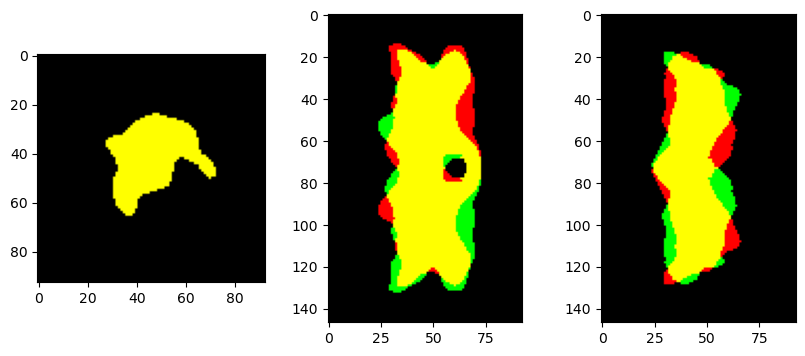

In [26]:
''' Display results in 2D'''
show_result_BFGS(Q, best_param)

In [38]:
''' Display results in 3D'''
show_result_BFGS(Q, best_param, V)